# Trying Task-Agnostic Amortized Inference ofGaussian Process Hyperparameters

In [1]:
# first we make sure that we have everything:
! pip install easydict PyYAML tensorboardX amor-hyp-gp 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [ ]:
! pip uninstall amor-hyp-gp 

Found existing installation: amor-hyp-gp 0.1.1
Uninstalling amor-hyp-gp-0.1.1:
  Would remove:
    /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ahgp/*
    /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/amor_hyp_gp-0.1.1.dist-info/*
    /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/model/*
Proceed (y/n)? 

In [12]:
! pip install "torch==1.6.0"

     |████████████████████████████████| 748.8 MB 2.6 kB/s  eta 0:00:01  |▏                               | 5.2 MB 9.5 MB/s eta 0:01:19    |█████████████████████████████▊  | 696.5 MB 322 kB/s eta 0:02:43
ERROR: fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
# imports:
import numpy as np
import torch

from easydict import EasyDict as edict
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from scipy import stats

import matplotlib.pyplot as plt

# from the package:
from ahgp.inference.hyperparam import hyperparam
from ahgp.gp.gp_helper import cal_kern_spec_mix_nomu_sep, GP_noise, standardize
from ahgp.inference.predict import predict

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/ec2-user/SageMaker/AHGP/src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Getting an intuition for the spectral misture Kernel

In [4]:
min_dim = 1
max_dim = 1
min_num_mix = 1
max_num_mix = 10
intensity_pt = 30
num_gps=1
seed=113
base_lengthscale = 0.1
max_lengthscale=1.5
min_lengthscale=0.05
p_large = 1/4.
epsilon = 1e-2


In [132]:
npr = np.random.RandomState(seed)
# M = max_num_mix

In [134]:
import math
from ahgp.gp.gp_helper import cal_kern_spec_mix_nomu_sep, cal_marg_likelihood, standardize, cal_marg_likelihood_single_L, cal_kern_spec_mix_sep

In [149]:
def plot_spectral_density(l_weights, l_var, l_mean, hight=7, length=25):

    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(length, hight))

    x_axes = np.linspace(-2, 30, 1000)
    
    spectral_density = np.zeros_like(x_axes)
    
    for i in range(len(l_weights)):
        spectral_density += l_weights[i] * stats.norm.pdf(x_axes, l_mean[i], l_var[i])

    ax.plot(x_axes, spectral_density)

    ax.set_title("The spectral density.")
    ax.set_xlabel("Frequency domain.")
    

def draw_from_spectral_density(l_weights, l_var, l_mean, N, D=1):
    # generate two seperate datasets, X and X_2
#     X = (npr.rand(N, D)-0.5)*2
#     X_2 = (npr.rand(N, D)-0.5)*2
    X = np.array([np.linspace(-2, 20, N)] * D).T
    X_2 = np.array([np.linspace(-2, 20, N)] * D).T
    X, X_2, _, _ = standardize(X, X_2)
    X = X * base_lengthscale
    X_2 = X_2 * base_lengthscale
    
#     var = np.expand_dim(l_var, axis=1)

    var_torch = torch.from_numpy(var).float().to(device)
    weights_torch = torch.from_numpy(weights).float().to(device)

    mu_torch = torch.from_numpy(mu).float().to(device)

    X_torch = torch.from_numpy(X).float().to(device)
    kern_matrix = cal_kern_spec_mix_sep(X_torch, X_torch, mu_torch, var_torch, weights_torch)
    X_2_torch = torch.from_numpy(X_2).float().to(device)
    kern_matrix_X2 = cal_kern_spec_mix_sep(X_2_torch, X_2_torch, mu_torch, var_torch, weights_torch)

    try:
        L = np.linalg.cholesky(kern_matrix.cpu().numpy()+epsilon*np.eye(N))
        L_2 = np.linalg.cholesky(kern_matrix_X2.cpu().numpy()+epsilon*np.eye(N))
    except Exception:
        print("failed")

    f = np.matmul(L, npr.randn(N, 1))
    f_2 = np.matmul(L_2, npr.randn(N, 1))
    f, mean_f, std_f = standardize(f)
    f_2, mean_f_2, std_f_2 = standardize(f_2)
    
    return f, f_2



In [155]:
# Define the parameters of the spectral density mixture:

D = 1
M = 6

setting = 4 # pick one from [0,1,2,4]
# changes the way the means of the Gaussian mixtures are picked

weights = (npr.dirichlet(np.ones(M), D)).T

length_normal = np.exp(npr.rand(M, D) * (math.log(max_lengthscale)-math.log(min_lengthscale)) + math.log(min_lengthscale))
var_normal = 1/length_normal**2/(2*math.pi**2)
is_length_large = npr.multinomial(1,[1-p_large,p_large],(D))
length_large = np.ones((M, D))*1000
var_small = 1/length_large**2/(2*math.pi**2)
var = is_length_large[:,0]*var_normal+is_length_large[:,1]*var_small

# this var generation does not quite work:
var = np.abs(np.random.randn(*var.shape)) + 0.01

mu = np.abs(np.random.randn(*var.shape) * 2)

if setting == 0:
    mu = np.zeros_like(mu)

elif setting == 2:
    
    mu[0] = 15
    mu[1] = 10

    var[0] = 0.2

    weights[0] = 0.8
    weights[1] = 0.2

elif setting == 4:
    max_mu = 30
    mu = np.random.rand(*var.shape) * max_mu
    
    

In [156]:
print("Weights: ", weights)
print("Sigmas: ", var)
print("Means: ", mu)

Weights:  [[0.1920041 ]
 [0.35030885]
 [0.06311186]
 [0.04017673]
 [0.31847758]
 [0.03592088]]
Sigmas:  [[0.41526763]
 [0.4111536 ]
 [1.47660244]
 [0.10641353]
 [0.84471896]
 [1.02365975]]
Means:  [[21.9914039 ]
 [ 4.29203045]
 [23.56751354]
 [22.04640971]
 [ 5.80059111]
 [ 1.72220646]]


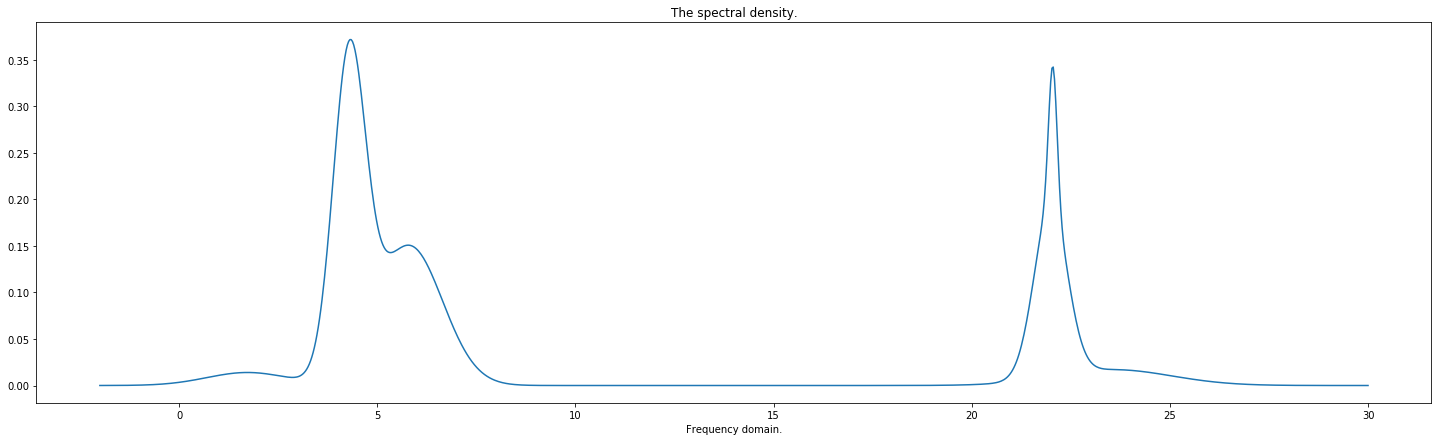

In [157]:
# Show the spectral density:
plot_spectral_density(np.squeeze(weights), np.squeeze(var), np.squeeze(mu))

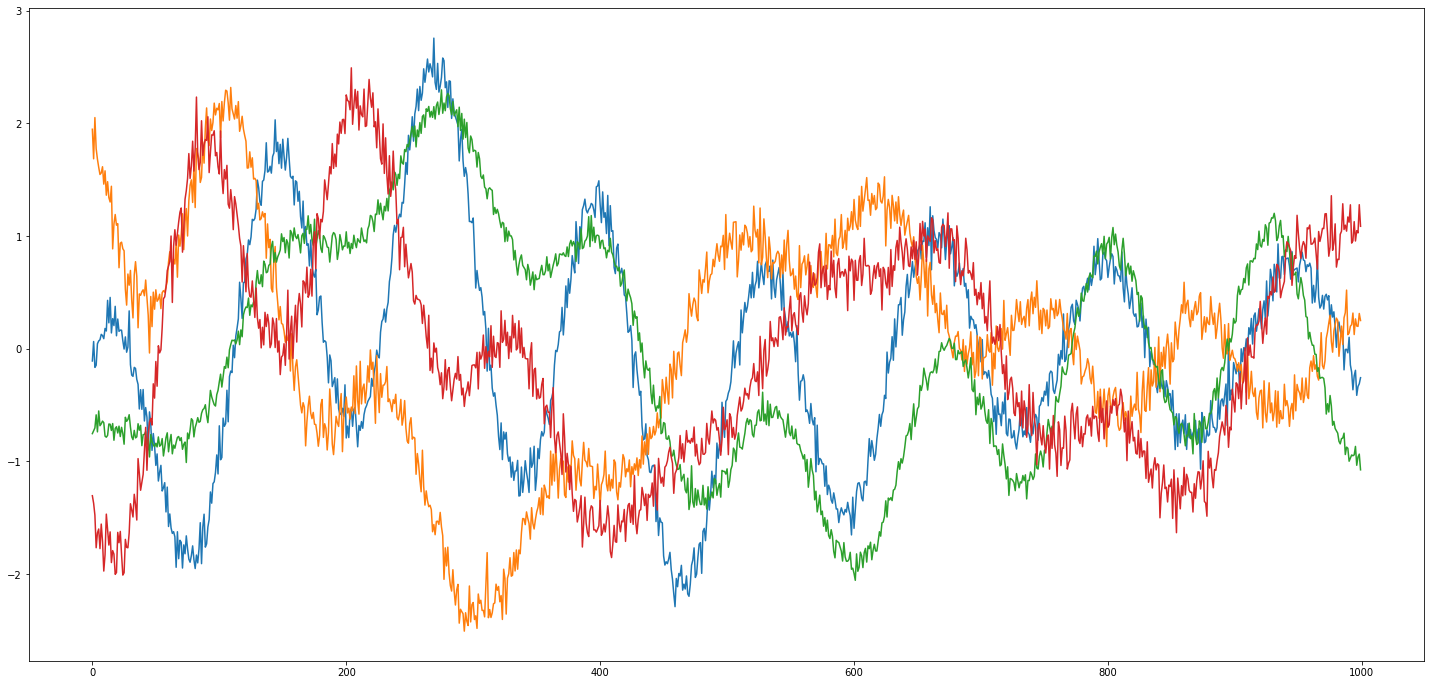

In [158]:
# Plot a couple of draws:

number_draws = 4

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(25, 12))


for i in range(number_draws // 2):
    f, f_2 = draw_from_spectral_density(weights, var, mu, 1000, D)
    
    ax.plot(f)
    ax.plot(f_2)


# Task 1: time series

We start with a time series task for easier visualisation.

In [168]:
# load data, but I don't have it now

x = np.arange(400)
y = x / 50 + np.sin(x / 8) * 10 + np.random.randn(len(x))


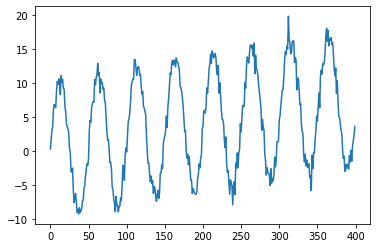

In [109]:
plt.plot(x,y)

In [110]:
# plitting the data in train and test
end_of_train = 300

x = np.expand_dims(x, axis=1)

x_train = x[:end_of_train]
x_test = x[end_of_train:]

y_train = y[:end_of_train]
y_test = y[end_of_train:]


In [176]:
from ahgp.inference import predict

def get_hyper_parameters_and_prediction(x_train, x_test, y_train, y_test, model_config_filename):
    # normalize x and y, AHGP will take in normalized x and y only
    x_train_norm, x_test_norm, _, _ = standardize(x_train, x_test)
    x_train_norm = x_train_norm*0.1
    x_test_norm = x_test_norm*0.1
    y_train_norm, mean_y_train, std_y_train = standardize(y_train)

    # yaml config file of the AHGP model
    # hyper_params are the hyperparameters of the spectral mixture product kernel
    hyper_params = hyperparam(x_train_norm,y_train_norm,x_test_norm,model_config_filename,use_gpu=False)
#     print(hyper_params)  
    mu = np.zeros_like(hyper_params["var"]) if not "mu" in hyper_params else hyper_params["mu"]
    plot_spectral_density(np.squeeze(np.array(hyper_params["weights"])), np.squeeze(np.array(hyper_params["var"])), np.squeeze(np.array(mu)), 6, 12)

    ## Predict:
    mu_test, var_test = predict(x_train_norm,y_train_norm,x_test_norm,model_config_filename,use_gpu=False)

    mu_test = mu_test * std_y_train + mean_y_train
    var_test = var_test * std_y_train**2

    rmse = np.mean((mu_test - y_test) ** 2) ** .5
    log_likelihood = np.mean(np.log(stats.norm.pdf(
                              y_test,
                              loc=mu_test,
                              scale=var_test ** 0.5)))
    print("RMSE: ", rmse, "log likelihood: ", log_likelihood)
    
    # plot prediction:
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
    ax.plot(x_train,y_train)
    ax.plot(x_test,y_test, color='b')
    ax.plot(x_test,mu_test)
    ax.fill_between(x_test[:,0], (mu_test-var_test), (mu_test+var_test), color='b', alpha=.1)
    

### Trial 1: pretrained network with no mu

RMSE:  8.40223558812355 log likelihood:  -3.5802714895509244


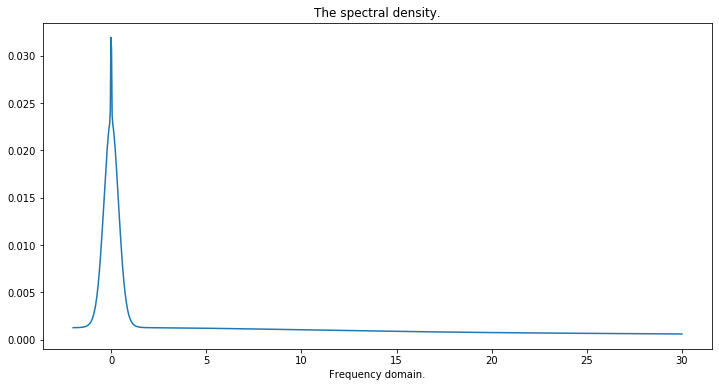

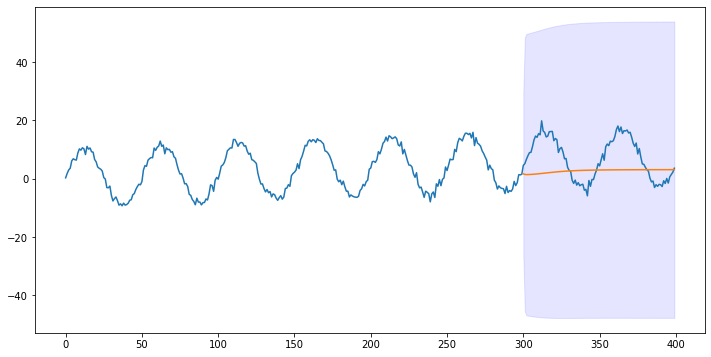

In [152]:
# Obtaining the predicted kernel hyper-parameters:

model_config_filename = "./config/model_nomu.yaml"
get_hyper_parameters_and_prediction(x_train, x_test, y_train, y_test, model_config_filename)

### Trail 2: using mu, but on a synthetic dataset where most of the mus are between 0 and 1

RMSE:  24.37509265840754 log likelihood:  -51.91669688274393


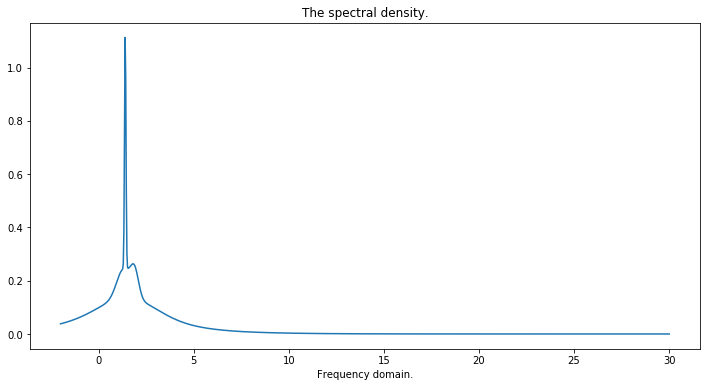

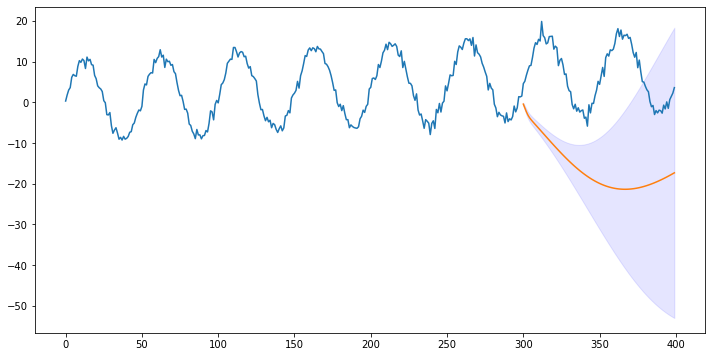

In [153]:
# Obtaining the predicted kernel hyper-parameters:

model_config_filename = "./config/model.yaml"
get_hyper_parameters_and_prediction(x_train, x_test, y_train, y_test, model_config_filename)


### Trail 3: using mu on a dataset with more varied mus

RMSE:  7.738387355516407 log likelihood:  -3.5771340258125957


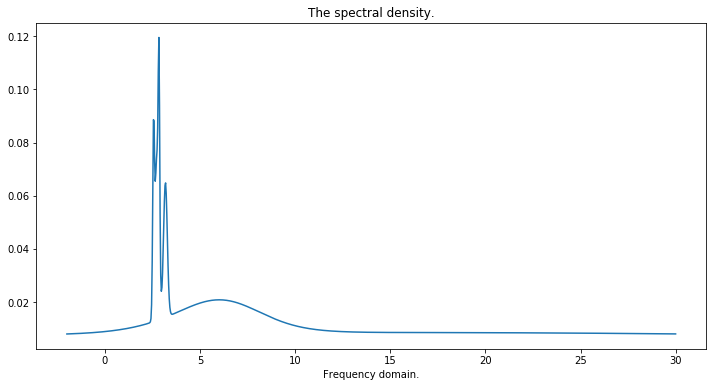

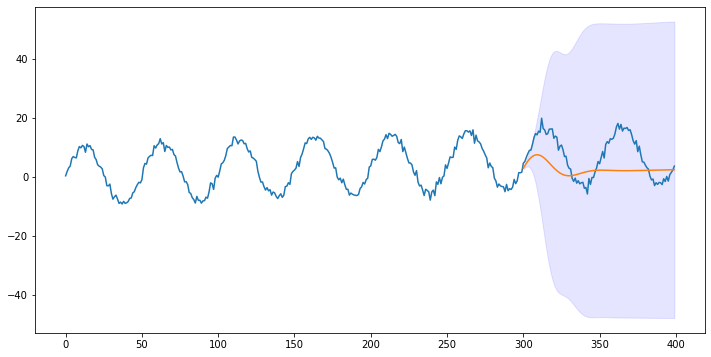

In [154]:

model_config_filename = "./config/model_ts.yaml"
get_hyper_parameters_and_prediction(x_train, x_test, y_train, y_test, model_config_filename)


Better, but still not quite what we want...

Is it because it usually does not require to "look more than one frequency in the past"?

# Task 0: with the original synthetic data generation process

We analyse what is happening using data generated from a GP using a spectral mixture kernel that could have been sampled for the training.


In [159]:
# Define the parameters of the spectral density mixture:

D = 1
M = 6

weights = (npr.dirichlet(np.ones(M), D)).T

# this var generation does not quite work:
var = np.abs(np.random.randn(*weights.shape)) + 0.01

max_mu = 30
mu = np.random.rand(*var.shape) * max_mu

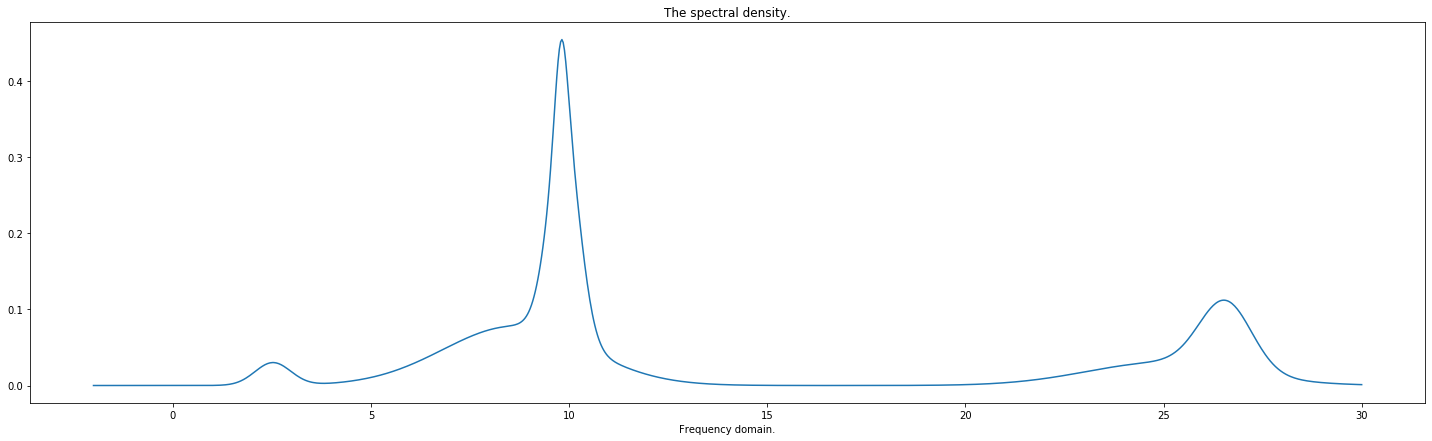

In [160]:
plot_spectral_density(np.squeeze(weights), np.squeeze(var), np.squeeze(mu))

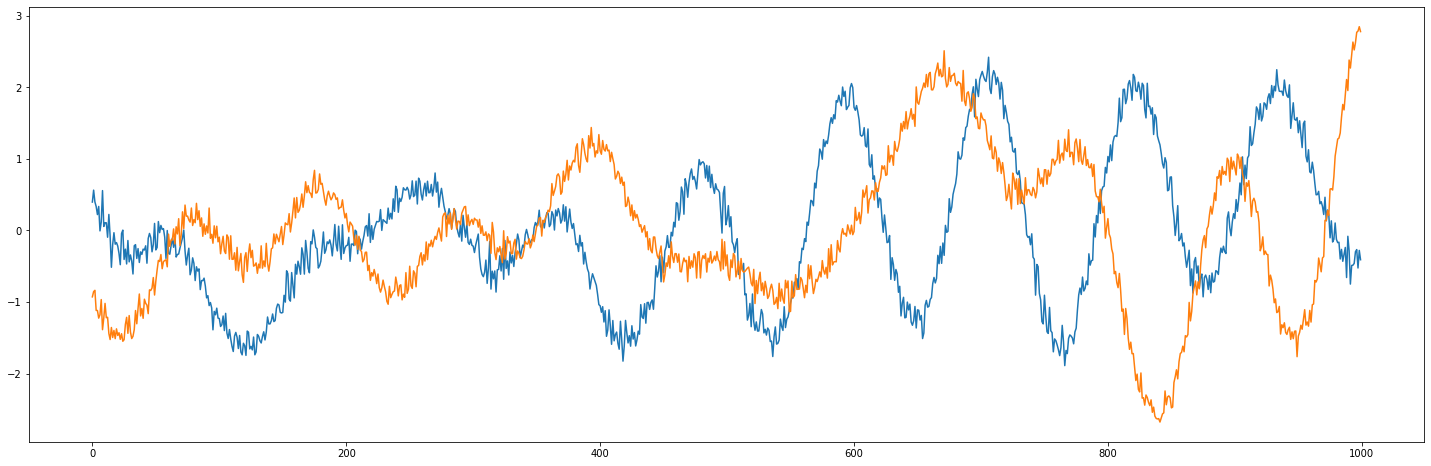

In [162]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(25, 8))

f, f_2 = draw_from_spectral_density(weights, var, mu, 1000, D)
ax.plot(f)
ax.plot(f_2)

In [174]:
end_of_train = 700

f = np.squeeze(f)

x = np.expand_dims(np.arange(f.shape[0]), axis=1)

x_train = x[:end_of_train]
x_test = x[end_of_train:]

y_train = f[:end_of_train]
y_test = f[end_of_train:]

RMSE:  1.3262676350857616 log likelihood:  -2.018140556320187


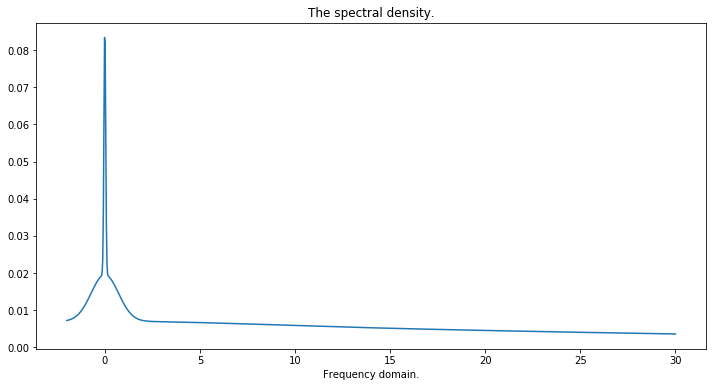

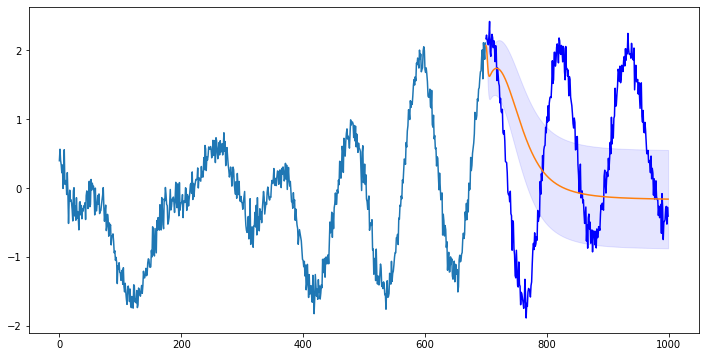

In [177]:
# No mu:
model_config_filename = "./config/model_nomu.yaml"
get_hyper_parameters_and_prediction(x_train, x_test, y_train, y_test, model_config_filename)

RMSE:  5.3567264938189565 log likelihood:  -86.86415250983956


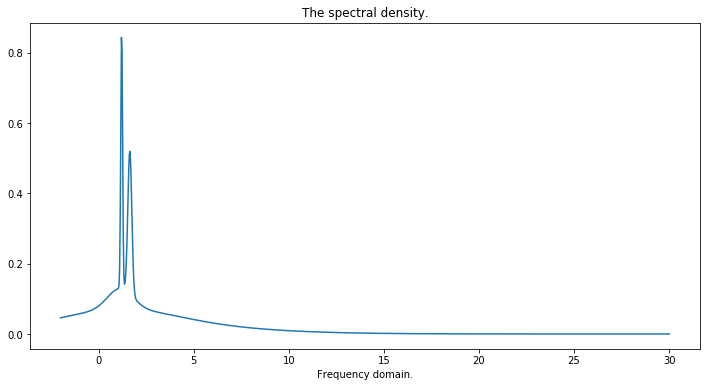

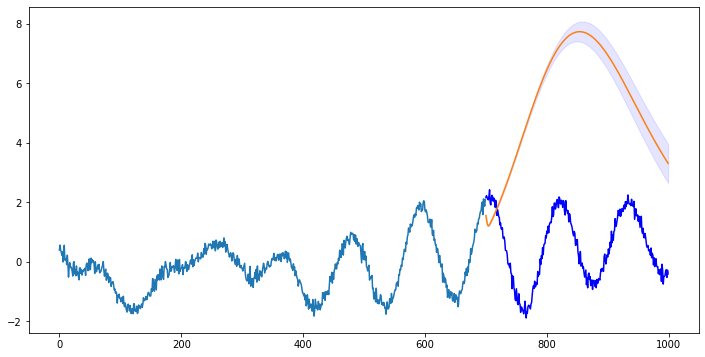

In [178]:
# Small mu:
model_config_filename = "./config/model.yaml"
get_hyper_parameters_and_prediction(x_train, x_test, y_train, y_test, model_config_filename)

RMSE:  1.1951126777138081 log likelihood:  -1.6492702409463362


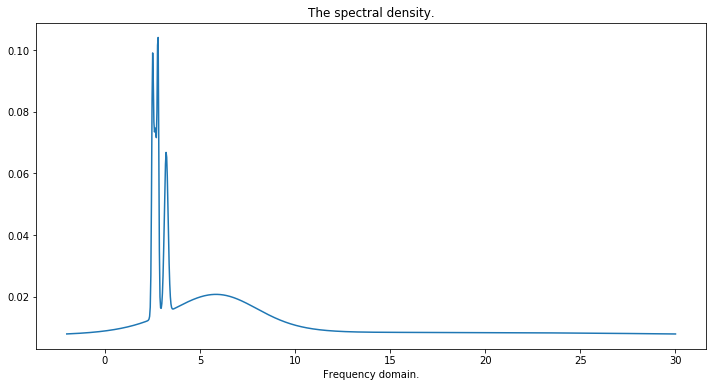

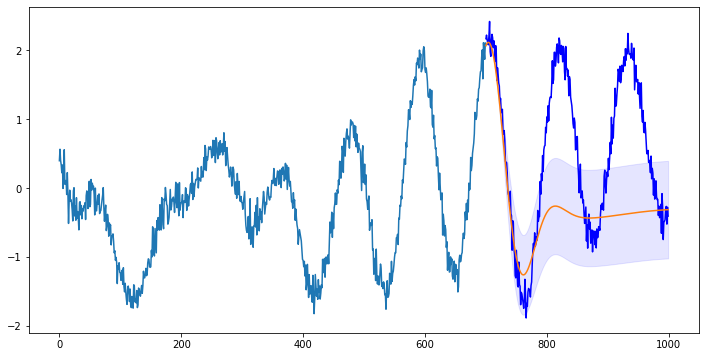

In [181]:
# Better mu:
model_config_filename = "./config/model_ts.yaml"
get_hyper_parameters_and_prediction(x_train, x_test, y_train, y_test, model_config_filename)

The model trained to recover these does not seem able to properly recover the mus. The model may need to be trained longer / tuned.

# Task 2: more standard regression

This is arguably a problem that is less concerning when doing regression, where a non periodic kernel may be just as good.



In [189]:

filename = "./data/regression_datasets/housing.data"
# filename = "./data/regression_datasets/concrete.data"
model_config_filename = "./config/model.yaml"

In [190]:
rand_seed = 10
npr = np.random.RandomState(rand_seed)
data = np.loadtxt(filename)
data = shuffle(data, random_state=npr)
x, y = data[:, :-1], data[:, -1]
data_dim = x.shape[1]
# normalize x and y, AHGP will take in normalized x and y only

x_t, x_v, y_t, y_v = train_test_split(x, y, test_size=.1, random_state=npr)
num_data = x_t.shape[0]
# normalize x and y, AHGP will take in normalized x and y only
x_t, x_v, _, _ = standardize(x_t, x_v)
x_t = x_t*0.1
x_v = x_v*0.1
y_t, mean_y_train, std_y_train = standardize(y_t)


mu_test, var_test = predict(x_t,y_t,x_v,model_config_filename,use_gpu=False)

mu_test = mu_test * std_y_train + mean_y_train
var_test = var_test * std_y_train**2

rmse = np.mean((mu_test - y_v) ** 2) ** .5
log_likelihood = np.mean(np.log(stats.norm.pdf(
                          y_v,
                          loc=mu_test,
                          scale=var_test ** 0.5)))
print(rmse)
print(log_likelihood)

3.0606537119221113
-2.434176249777962


# Next step:
- use this as a warm start rather than the final parameters: so train a GP with ML initialising at the found parameters
- train the model better (this is just running it out of the box with no tunning, just playing around with the data generation and using the mu)
- look into the way the mus are predicted and if something could be improved
- can we approximate the Gaussians in the spectral domain with Materns and so use this in state space GPs?